# Mode prediction -- multiple steps -- different features

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [107]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

## Processing functions

In [108]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [109]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))
    
    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    f = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(np.array(pred), color=colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.show()

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))

    print(acc)
    print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    _, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()


'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    _, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.show()

In [110]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

In [111]:
op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']
test = read_dataset(dataset, campaigns=[op1_overlap[0]])
train = read_dataset(dataset, campaigns=op1_overlap[1:4])

route_to_add = read_dataset(dataset, campaigns=[op1_overlap[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(dataset, campaigns=[op1_overlap[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [112]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

## 1 step ahead

In [113]:
# parameters
n_steps_in = 2
n_steps_out = 1
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.549,0.504,0.043,0.764,0.420,0.100
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.549,0.000,0.000,0.773,0.000,0.000
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.536,0.304,0.021,0.778,0.608,0.061
6,"RSRP, SINR, RSRQ",0.494,0.451,0.552,0.674,0.375,0.656
7,SSS_RSRP,0.653,0.577,0.870,0.506,0.315,0.999
8,SSS_SINR,0.568,0.594,0.137,0.742,0.433,0.430
9,SSS_RSRQ,0.656,0.659,0.495,0.716,0.438,0.883


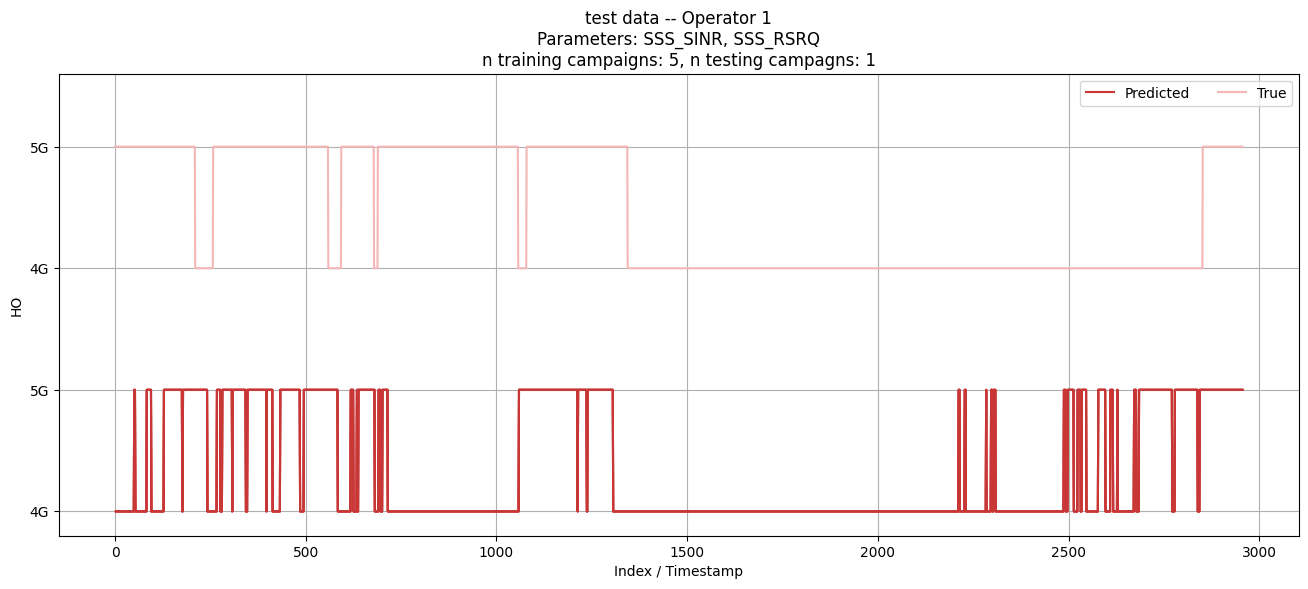

In [114]:

combination = 'SSS_SINR, SSS_RSRQ'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

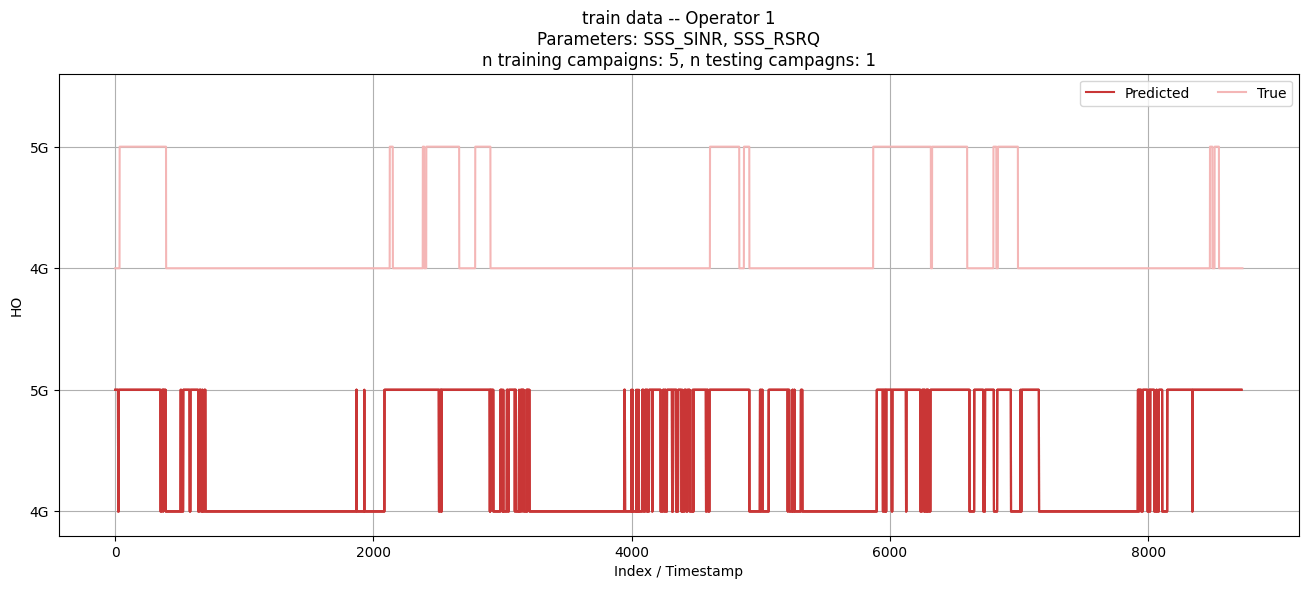

In [115]:
plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

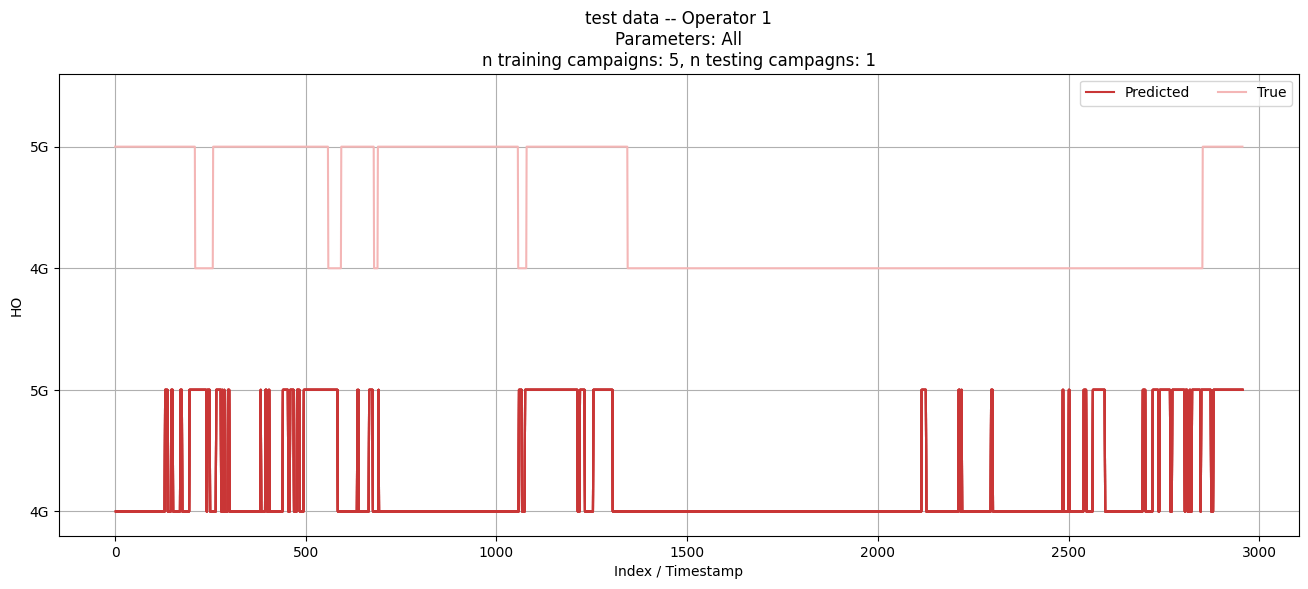

In [116]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)


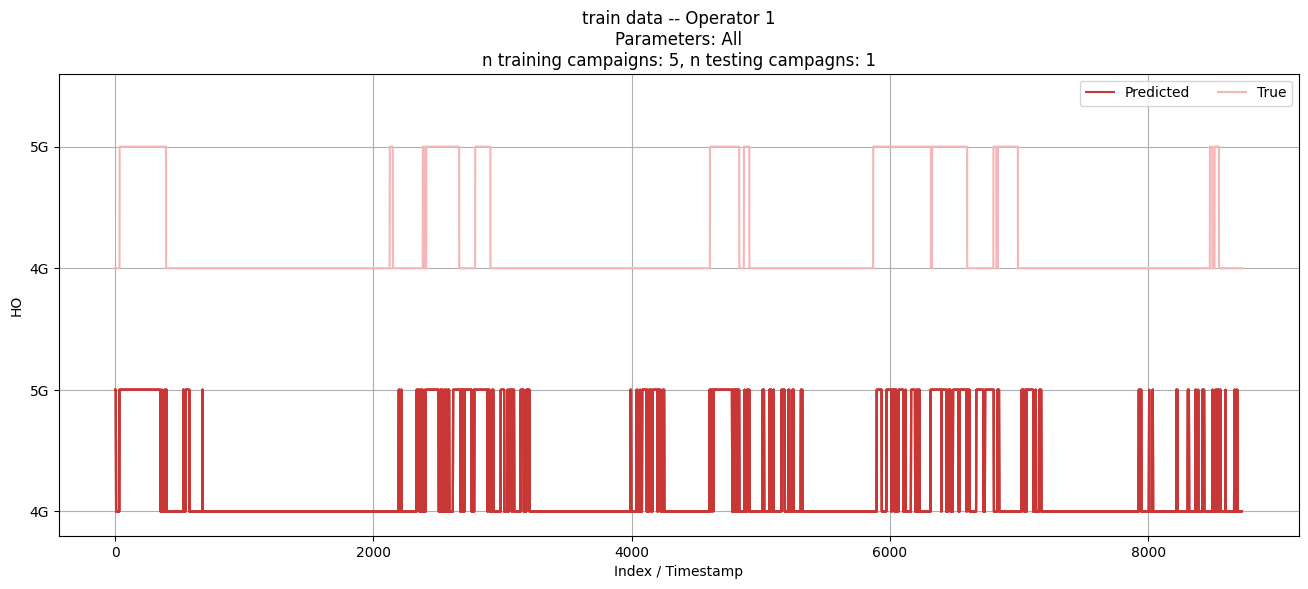

In [117]:
plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

## 2 steps ahead

In [118]:
# parameters
n_steps_in = 2
n_steps_out = 2
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.549,0.504,0.044,0.769,0.461,0.098
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.549,0.000,0.000,0.762,0.114,0.007
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.546,0.000,0.000,0.772,0.469,0.038
6,"RSRP, SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
7,SSS_RSRP,0.549,0.000,0.000,0.773,0.000,0.000
8,SSS_SINR,0.551,0.520,0.073,0.739,0.376,0.227
9,SSS_RSRQ,0.583,0.631,0.183,0.774,0.501,0.581


Number of predicted 5G point: 1922
[0.6201760324983073, 0.6208530805687204]
[0.7762735199632859, 0.7756998623221661]


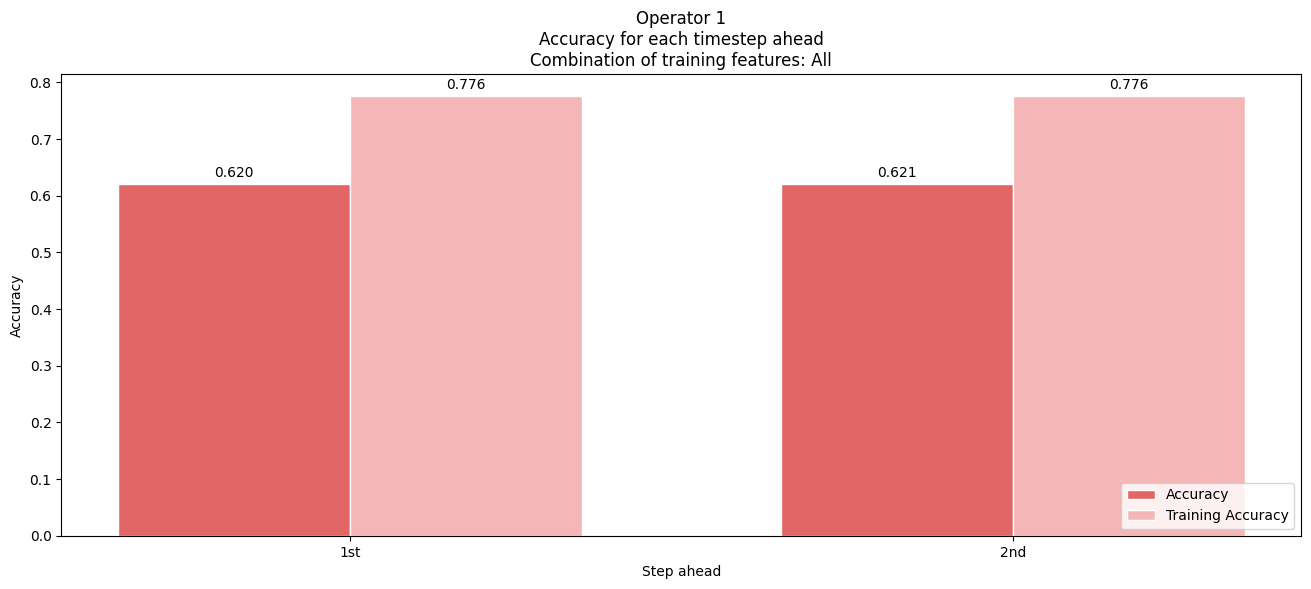

In [119]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

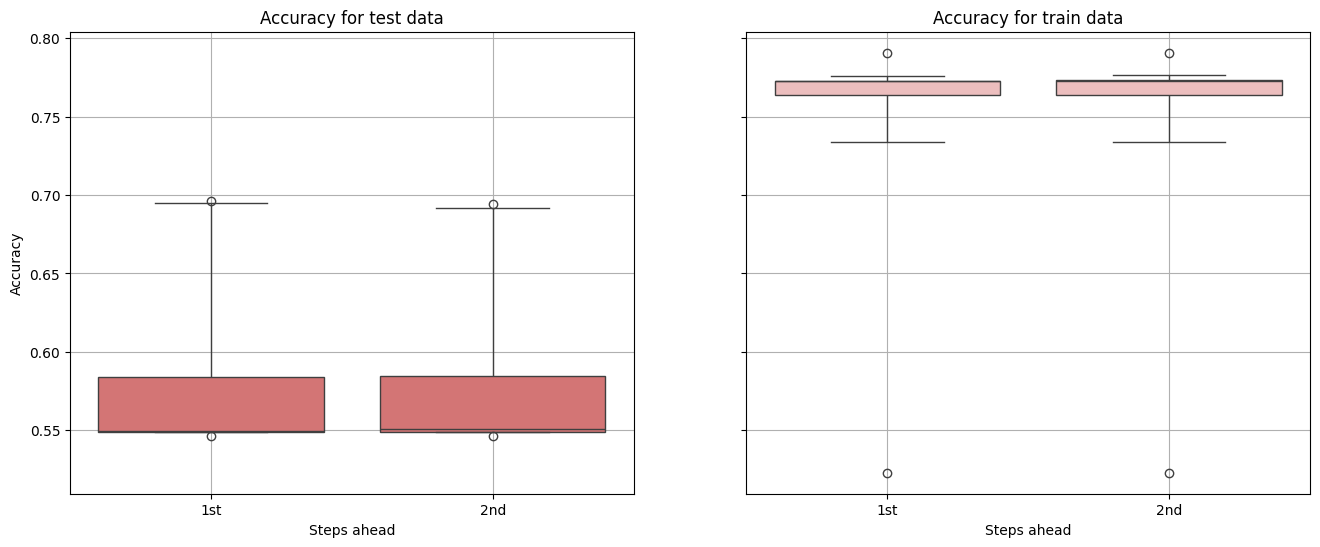

In [120]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)

## 3 steps ahead

In [121]:
# parameters
n_steps_in = 3
n_steps_out = 3
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.551,0.526,0.046,0.766,0.424,0.086
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.549,0.000,0.000,0.773,0.000,0.000
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
6,"RSRP, SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
7,SSS_RSRP,0.659,0.597,0.751,0.569,0.343,0.979
8,SSS_SINR,0.567,0.571,0.162,0.745,0.447,0.522
9,SSS_RSRQ,0.645,0.665,0.428,0.731,0.446,0.777


Number of predicted 5G point: 3709
[0.5860433604336044, 0.5857046070460704, 0.5857046070460704]
[0.7374224672639559, 0.7383413737652194, 0.7385711003905353]


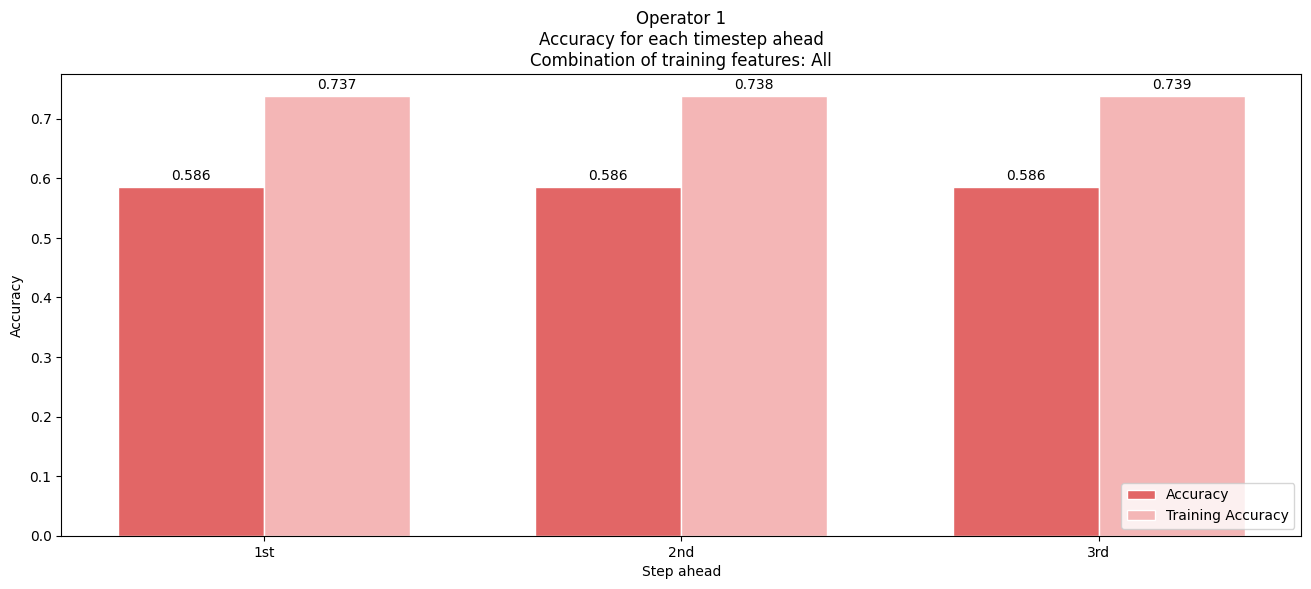

In [122]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

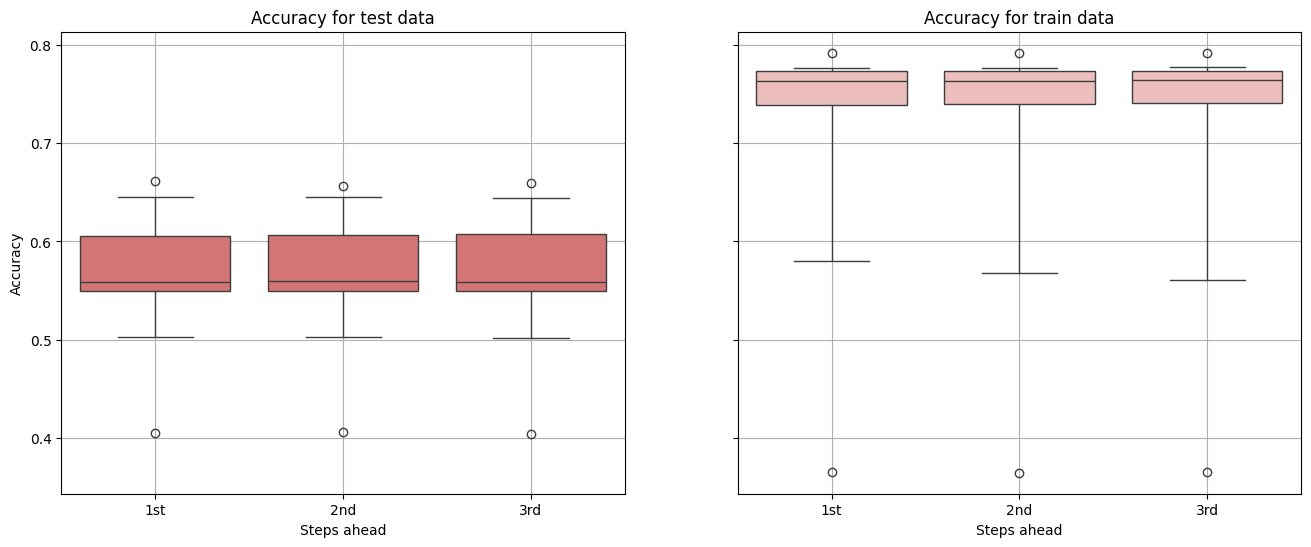

In [123]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)

## 5 steps ahead

In [124]:
# parameters
n_steps_in = 5
n_steps_out = 5
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.550,0.000,0.000,0.774,0.000,0.000
1,SINR,0.550,0.000,0.000,0.774,0.000,0.000
2,RSRQ,0.550,0.000,0.000,0.774,0.000,0.000
3,"RSRP, SINR",0.550,0.000,0.000,0.766,0.229,0.015
4,"RSRP, RSRQ",0.550,0.000,0.000,0.774,0.000,0.000
5,"SINR, RSRQ",0.583,0.617,0.194,0.747,0.380,0.185
6,"RSRP, SINR, RSRQ",0.550,0.000,0.000,0.774,0.000,0.000
7,SSS_RSRP,0.454,0.452,1.000,0.231,0.227,1.000
8,SSS_SINR,0.567,0.573,0.146,0.757,0.455,0.390
9,SSS_RSRQ,0.598,0.636,0.251,0.761,0.479,0.683


Number of predicted 5G point: 4907
[0.6082089552238806, 0.6061736770691994, 0.6058344640434192, 0.6051560379918589, 0.6037991858887382]
[0.7396960626295188, 0.7399263182132166, 0.7400414460050656, 0.7393506792539719, 0.7392355514621229]


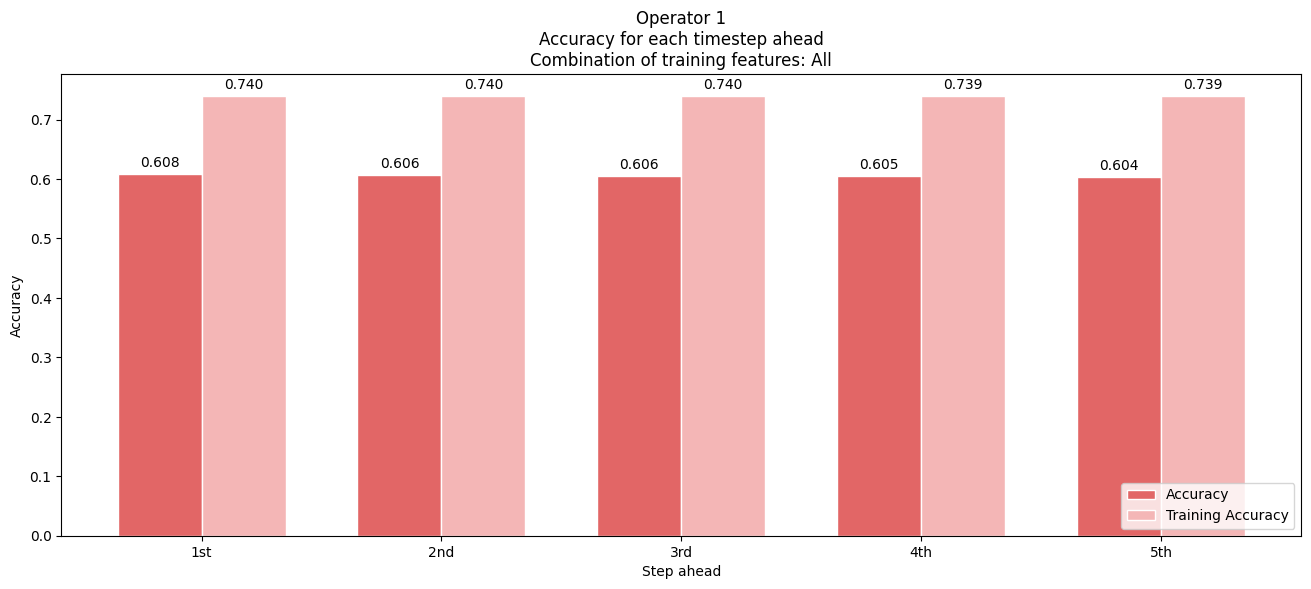

In [125]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

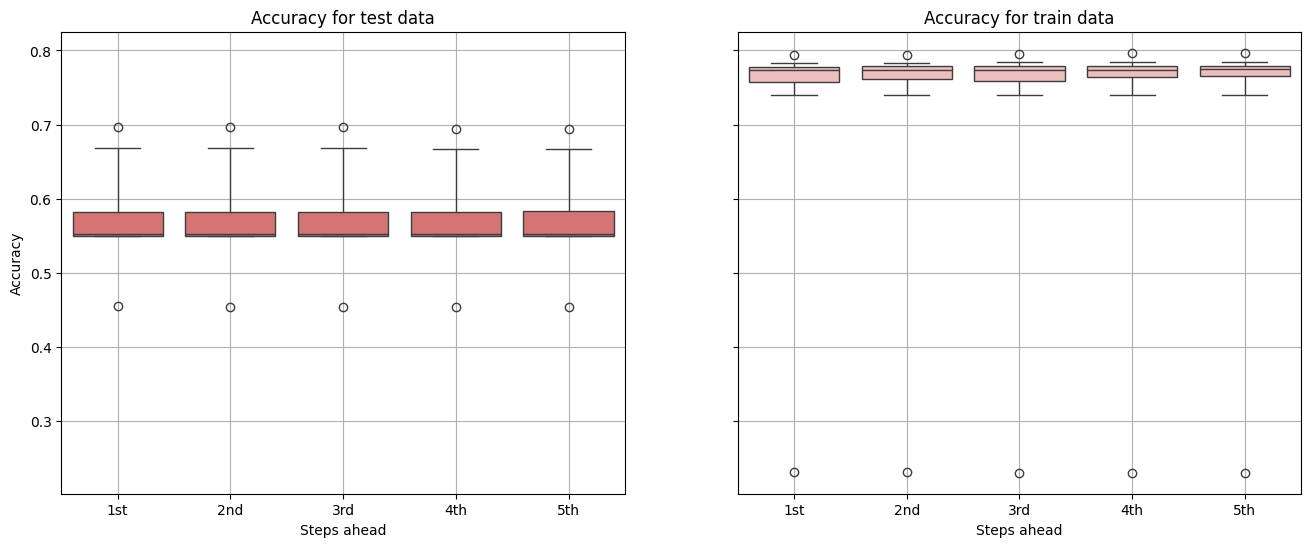

In [126]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)

## 10 steps ahead

In [127]:
# parameters
n_steps_in = 8
n_steps_out = 10
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.551,0.000,0.000,0.775,0.000,0.000
1,SINR,0.516,0.317,0.068,0.761,0.422,0.164
2,RSRQ,0.551,0.000,0.000,0.775,0.000,0.000
3,"RSRP, SINR",0.565,0.700,0.053,0.731,0.220,0.075
4,"RSRP, RSRQ",0.551,0.000,0.000,0.775,0.000,0.000
5,"SINR, RSRQ",0.551,0.000,0.000,0.775,0.000,0.000
6,"RSRP, SINR, RSRQ",0.541,0.395,0.042,0.724,0.262,0.124
7,SSS_RSRP,0.551,0.000,0.000,0.775,0.000,0.000
8,SSS_SINR,0.588,0.655,0.172,0.765,0.477,0.477
9,SSS_RSRQ,0.601,0.633,0.263,0.759,0.477,0.715


Number of predicted 5G point: 7245
[0.6948979591836735, 0.6938775510204082, 0.6928571428571428, 0.6918367346938775, 0.6908163265306122, 0.6891156462585034, 0.6880952380952381, 0.6870748299319728, 0.685374149659864, 0.6850340136054421]
[0.8123987971316216, 0.8129770992366412, 0.813324080499653, 0.8132084200786491, 0.8126301179736294, 0.811704834605598, 0.8105482303955587, 0.8093916261855193, 0.8085820032384918, 0.8077723802914643]


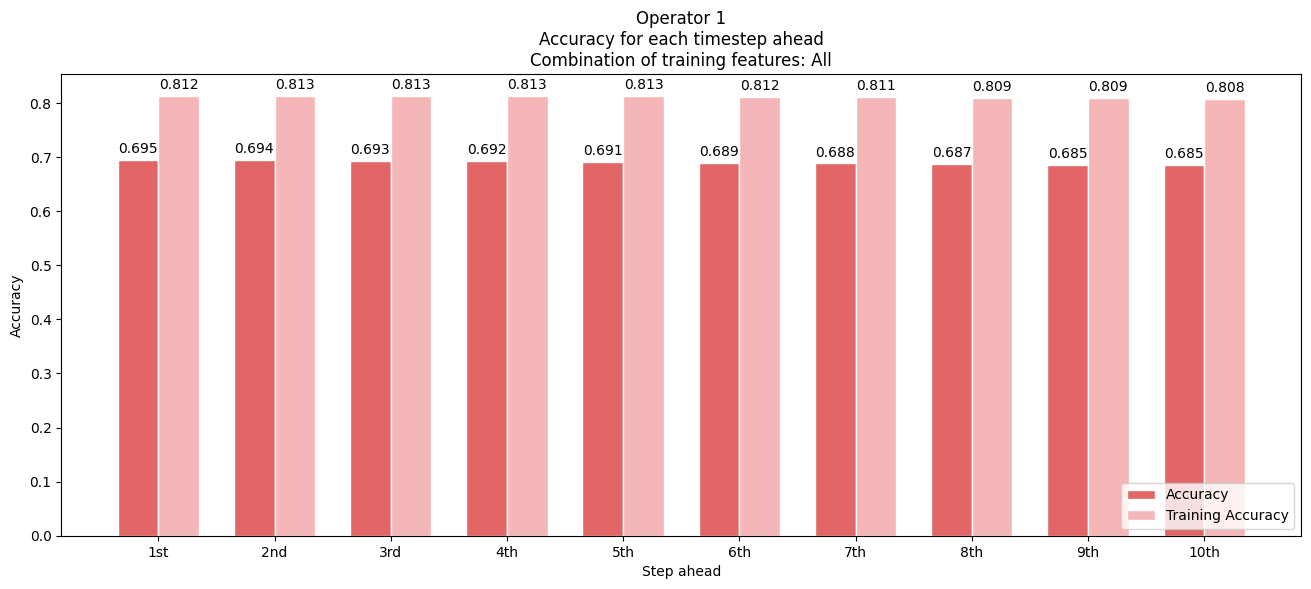

In [128]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

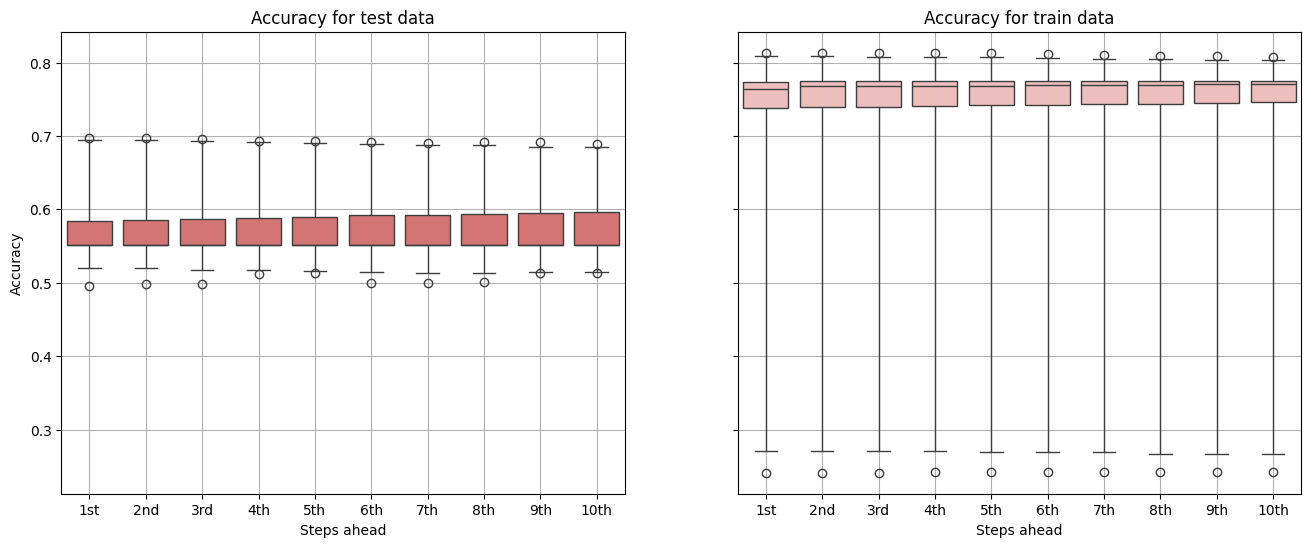

In [129]:
boxplot_accuracies(results=results, n_steps_out=n_steps_out)